# Statistical Learning Model

**Goals:**
 - Quickly check the data using samples of maching learning models
 - Grasp some insights on the data
 - Data clearning

Use the the target labels to fit the first model - base model.

Import libraries

In [87]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import time

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.tree import plot_tree


%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Load raw data with labels

In [4]:
df = pd.read_csv('./raw_data/raw_data_with_labels.csv', index_col=0)

# select only data with labels
df = df[df['y'].notnull()]
print('Num of labelled data: ', df.shape)

Num of labelled data:  (527, 4)


In [5]:
df.head()
df.tail()

,title,y,upload_date,view_count
1300,"ML Bootcamp - Decision Tree, Random Forest & E...",0.0,20200804,2164
1301,Kaggle 3 Free Certificates | Python | Machine ...,0.0,20200802,3227
1302,Kaggle 101: Learn & Earn (Introduction),0.0,20200731,193
1303,#3 - Learn Python with Kaggle - Booleans and C...,0.0,20200731,445
1304,Pytorch Tutorial 5-Live- Kaggle Advance House ...,1.0,20200730,9441


# 1. Data Cleanup

Using a NEW dataframe with data that's ready and clean to fit the ML model.

In [6]:
# create a clean dataframe with the same indice on the original dataframe - raw data
df_clean = pd.DataFrame(index=df.index)

In [7]:
df_clean['date'] = pd.to_datetime(df['upload_date'], format='%Y%m%d')

# note: format='%Y %m %d' shows the time; format='%Y%m%d' brings only YYYY-MM-DD - easy!

In [8]:
df_clean['date']

# dtype: datetime64[ns] used by numpy and pands

0      2021-05-05
1      2021-05-05
2      2021-05-05
3      2021-05-05
4      2021-05-05
          ...    
1300   2020-08-04
1301   2020-08-02
1302   2020-07-31
1303   2020-07-31
1304   2020-07-30
Name: date, Length: 527, dtype: datetime64[ns]

In [9]:
# columns views: make sure all NAN will be convert to 0 and the assing an integer data type
df_clean['views'] = df['view_count'].fillna(0).astype(int)

In [10]:
df_clean.dtypes

date     datetime64[ns]
views             int32
dtype: object

## 2.Features

Create an unique features dataframe.

**Reason**: Align the feaatures dataframe with the most cleaning data - raw data collected & cleaned. The cleaning process can skip rows or columns.


In [95]:
# features: it's similar to df_clean, just an extra step
features = pd.DataFrame(index=df_clean.index)

# labels/targets
y = df['y'].copy()

In [96]:
print('Features shape: {}'.format(shape(features)))
print('Labels shape: {}'.format(shape(y)))

Features shape: (527, 0)
Labels shape: (527,)


## Important: sklearn can't use *date* as a feature.

Let's manipulate and create a feature using the raw date - **Num_views_per_day**.

Sklearn needs a number.

In [97]:
# time_since_pub: time since the video was published. Random data choose. Use the date I created this code: fix date point

# np.timedelta64(1, 'D'): time delta in numpy. Difference in days
# we have data on a granually day meaning a difference less than a ay makes sense.
features['time_since_pub'] = (pd.to_datetime("2021-05-09") - df_clean['date']) / np.timedelta64(1, 'D')

# used features
features['views'] = df_clean['views']
features['views_per_day'] = features['views'] / features['time_since_pub']

features = features.drop(['time_since_pub'], axis=1)   # time_since_pub only used for the calculation

# time_since_pub as a feature may impact the model once the numbers seem to increase a lot and the end of the time serie.
# The training&validations datasets may not have a normal distributed values, thus an umbalaced feature weights.
# and random samples are important to train and fit a ml model


In [98]:
features.head()
features.tail()


,views,views_per_day
1300,2164,7.784173
1301,3227,11.525000
1302,193,0.684397
1303,445,1.578014
1304,9441,33.360424


In [99]:
### not working
#df_clean['date'].value_counts().plot(figsize=(20.10))

features.describe()

,views,views_per_day
count,5.270000e+02,527.000000
mean,1.598783e+04,308.274453
std,8.183696e+04,1154.782875
min,0.000000e+00,0.000000
25%,1.750000e+02,3.082796
50%,1.151000e+03,24.500000
75%,6.595500e+03,170.016129
max,1.472872e+06,17745.445783


## 3. Fitting a baseline model

Let's try to split the train&validation datasets 50/50.

How the 2 features view and views_per_day impacted the ML model? 

Does a simple model with only 2 features impact the way the YouTube videos will be selected?

In [100]:
# check all data on df_clean
# pd.set_option('display.max_rows', 527)
# df_clean

median_date = df_clean['date'].quantile(0.5, interpolation="midpoint")
median_date

Timestamp('2021-03-12 00:00:00')

In [101]:
# splitting features dataset - trying a 50/50 using the median date
# balanced dataset is important
Xtrain, Xval = features[df_clean['date'] < '2021-03-12 '], features[df_clean['date'] >= '2021-03-12 ']
ytrain, yval = y[df_clean['date'] < '2021-03-12 '], y[df_clean['date'] >= '2021-03-12 ']

Xtrain.shape, Xval.shape, ytrain.shape, yval.shape

((263, 2), (264, 2), (263,), (264,))

## Decision Tree Model

**Parameters**:
 - 2 depth only - keep simple
 - class_weight='balanced' ==> positive (1) samples, and zero are unbalanced and may impacte the ML model

In [104]:
# check number of 1 samples under train dataset
print('Positive samples - videos select: {}'.format(ytrain.mean() * 263))
print(' % of ositive samples - videos select: {}'.format(ytrain.mean() * 100))

# definitely unbalaced

Positive samples - videos select: 104.0
 % of ositive samples - videos select: 39.543726235741445


In [105]:
clf_dt = DecisionTreeClassifier(random_state=0, max_depth=2, class_weight='balanced')    # defined object

## Fitting the model against the train dataset

In [106]:
clf_dt.fit(Xtrain, ytrain)

C:\Users\danie\Anaconda3\lib\site-packages\sklearn\tree\tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)


DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [114]:
print('ML model already trainded/fitted and ready to be used!')

ML model already trainded/fitted and ready to be used!


## Predicting if a video has been select

Probability = 1

predict_proba: returns a numpy array with prob of zero and prob of 1

In [107]:
pred = clf_dt.predict_proba(Xval)[:, 1]   # only 1

## Metrics - validating the model


In [108]:
# area of precision for decision tree

print('Baseline model - decision tree with only simple parameters: 2 level deep')
average_precision_score(yval, pred)

Baseline model - decision tree with only simple parameters: 2 level deep


0.4247003740078532

## IMPORTANT: any future model in PRD should have a greater value

In [109]:
# area under curve of roc curve metric
roc_auc_score(yval, pred)

0.49467836257309944

## Decision Tree Plot 


[Text(418.5, 679.5, 'views_per_day <= 20.987\ngini = 0.5\nsamples = 263\nvalue = [131.5, 131.5]'),
 Text(209.25, 407.69999999999993, 'views_per_day <= 0.297\ngini = 0.481\nsamples = 154\nvalue = [88.494, 59.428]'),
 Text(104.625, 135.89999999999998, 'gini = 0.0\nsamples = 12\nvalue = [9.925, 0.0]'),
 Text(313.875, 135.89999999999998, 'gini = 0.49\nsamples = 142\nvalue = [78.569, 59.428]'),
 Text(627.75, 407.69999999999993, 'views <= 2423.5\ngini = 0.468\nsamples = 109\nvalue = [43.006, 72.072]'),
 Text(523.125, 135.89999999999998, 'gini = 0.0\nsamples = 2\nvalue = [1.654, 0.0]'),
 Text(732.375, 135.89999999999998, 'gini = 0.463\nsamples = 107\nvalue = [41.352, 72.072]')]

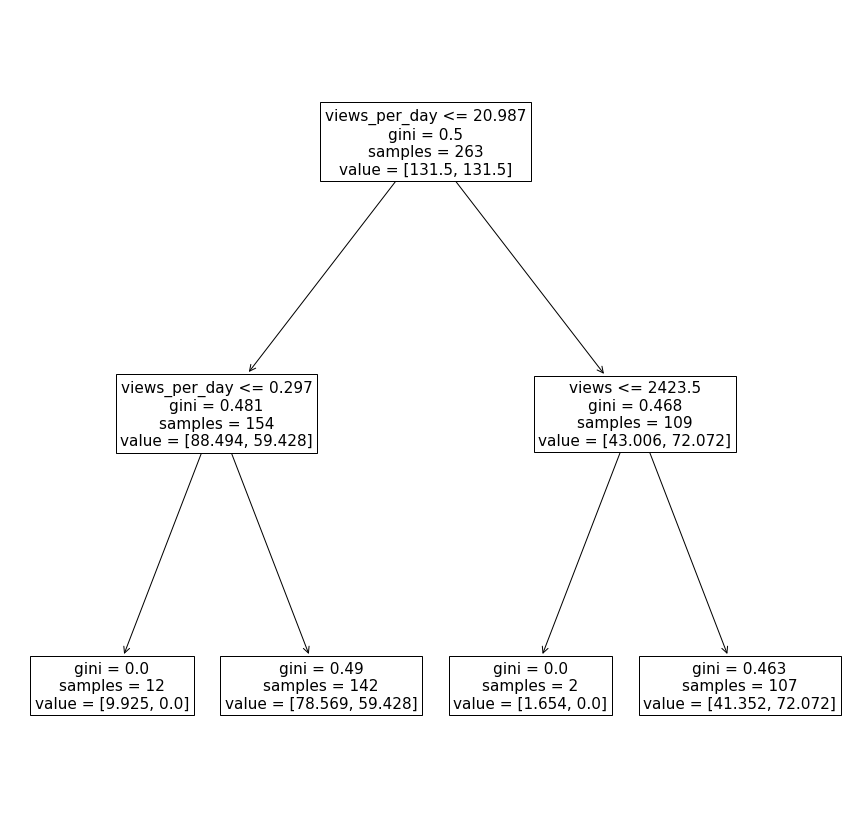

In [112]:
fig, ax = pylab.subplots(1,1, figsize=(15,15))
plot_tree(clf_dt, ax=ax, feature_names=Xtrain.columns)

## Quick glance of the machine learning model
## Overall details for the Decision Tree statistical model

The parameter **class_weight='balanced'** worked punishing the positive samples that contain less samples. The root node shows the value with the same number meaning that the model tries to balance the samples.

Videos with less than 20 views per day - root node - and with less the 1 view per day will not be recommended - y label gets zero.
The model seems to make sense once not popular video should not be recommended.

On the other hand, the left side on the tree shows videos with more views per day - likely popular videos - and with more than ~2400 views will be recommended.
However, 'popular videos' with more than 20 views per day but with no more than ~2400 will not be recommented - get ZERO label.

**Please note**: it's a first very simple model (2 levels deep and only 2 features) trying to get a baseline metric.